# Convolutional neural network for classifying Root data fits.


Here, we define, train, and save new convolutional models as well as some 
simple model evaluation. We define hyper-parameters, number of layers, and 
training and testing datasets. 

Here, at the final layer, the network takes into account chi squared per degree of freedom.

## Load necessary packages

In [1]:
# Load some packages

# Keras packages for network
from keras.layers import Input, Dense, Activation, ZeroPadding2D
from keras.layers import BatchNormalization, Concatenate, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Conv2D
from keras.models import Model
from keras.optimizers import Adam, SGD
# For saving model
from keras.models import model_from_json
# For plotting and drawing after training
from keras.utils import plot_model

# Need numpy for linear algebra
import numpy as np
# Need misc ad matplotlib for image manipulation
from scipy import misc
#from PIL import Image
import matplotlib.pyplot as plt

# Import personal functions for loading dataset
import nn_utils as utils

# Use magic function for plotting
%matplotlib inline

Using TensorFlow backend.


## Load root fit data from file

Here, we load training data set and labels for training our CNN. 

### *Convolutional dataset consists of*
 - Linear scale png output of data points and fit lines
 - Log scale png output from the same fit
 - Fit input parameters such as high voltage, light level, minimum and maximum bounds to parameters
 - Fit output parameters such as signal mean and rms, gain measurement, chi squared per DOF, errors on parameters, etc.
 - Label (0 = bad fit, 1 = good fit)

In [2]:
# Load training images
x, x_log, in_params, out_params, y = utils.load_dataset_no_sql(dataset="train")
m, h, w, c = x.shape
input_shape = h, w, c
print(str(m) + " images loaded of shape " + str(input_shape))
print(str(y.shape[0]) + " labels loaded")
num_inputs, num_outputs = len(in_params[1]), len(out_params[1])
print(str(len(in_params)) + " input arrays loaded of length " + str(num_inputs))
print(str(len(out_params)) + " output arrays loaded of length " + str(num_outputs))

16 images loaded of shape (236, 348, 3)
16 labels loaded
16 input arrays loaded of length 38
16 output arrays loaded of length 20


### Load DEV set

Here, we load development set images for model evaluation.

In [3]:
# Load training images
x_dev, x_log_dev, in_params_dev, out_params_dev, y_dev = utils.load_dataset_no_sql(dataset="dev")
m_dev = x_dev.shape[0]
print(str(m_dev) + " dev examples loaded")

2 dev examples loaded


### Print an image

label: good
label: [1]

fit_inputs: [ 4.00000000e+00  2.00000000e+03  1.00000000e+02  2.00000000e+03
  4.60000000e+01  7.00000000e+00  0.00000000e+00  1.00000000e+03
  1.00000000e+00  1.00000000e+00  1.60000000e+01  5.00000000e-02
  6.13806921e+02  2.59090800e+00  5.00000000e-03  1.38000000e+00
  4.00000000e+00  2.59090800e+00  4.76190000e-02  9.52381000e-01
  1.00000000e-03 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  1.24200000e+00 -1.00000000e+00 -1.00000000e+00  4.28570000e-02
  9.47619000e-01  3.00000000e-01 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00  1.51800000e+00 -1.00000000e+00 -1.00000000e+00
  5.23810000e-02  9.57143000e-01]

fit_outputs: [4.49600000e-03 6.11732964e+02 1.91337200e+00 3.73860000e-02
 1.31145900e+00 8.02303000e-01 5.13300000e-02 9.47619000e-01
 1.66000000e-04 4.60230000e-02 1.78770000e-02 1.15600000e-03
 3.39900000e-02 7.35670000e-02 1.16100000e-03 8.12000000e-04
 3.33283400e+00 5.86704000e-01 1.78910000e-02 3.04934300e+00]


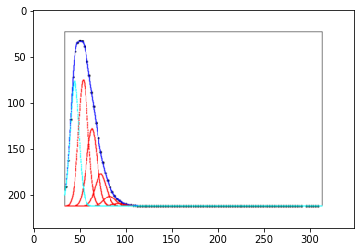

In [4]:
# Print an image
index = 2
# Choose log or linear scale
log_scale = False
this_image = x_log[index] if log_scale else x[index]
if y[index] == 1:
    print("label: good")
else:
    print("label: bad")
print("label: " + str(y[index]))
print("\nfit_inputs: " + str(in_params[index]))
print("\nfit_outputs: " + str(out_params[index]))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

# Define and train convolutional neural net

### *Architecture:*
 - We will actually train two conv nets in parallel side-by-side, one looking at linear scale images while the other looks at log scale images. 
 - After we put the images through the multiple convolutional layers, we will flatten them into 1D arrays and concatenate them together.
 - To this array, we will concatenate all the useful values that were input to and output from the fit algorithm.
 - We now should have all the information avaiable from the fit contained in a single array of values that we can send into a deep, fully-connected network for classification.

### *Convolutional layers:*
 - We use 3 conv layers with batch normalization, dropout, and minimal pooling.
 - In a single convolutional layer, we will scan over our images with a certain stride and a certain kernal size (with multiple filters each time). 
 - As long as our kernel size or stride is greater than 1, we will be decreasing the size of the image with each pass through a convolutional layer (we are using no padding). 
 - Through applying filters in convolution as well as using max pooling, we will end up with a very reduced representation of our image; we hope that this still contains all the information necessary to classify it as a good/bad fit.

In [5]:
# Define Conv layers
filters = []
kernels = []
strides = []
pools = []
dropouts = []

# Conv1
filters.append(32)
kernels.append(5)
strides.append(3)
pools.append(1)
dropouts.append(0.1)

# Conv2
filters.append(64)
kernels.append(7)
strides.append(2)
pools.append(1)
dropouts.append(0.1)

# Conv3
filters.append(128)
kernels.append(9)
strides.append(3)
pools.append(2)
dropouts.append(0.2)

# Define dense layers
neurons = [100, 80, 60, 40, 20, 10]

## Define keras layers (model)

Our model contains two convolutional models in parallel, each with multiple layers. We run two in parallel to utilize log scale images AND linear scale (different information present). 

After we convolve the images, we flatten them and concatenate them. We also concatenate to them a list of inputs and outputs to and from the root fit algorithm such as parameter initial condition and bounds, output parameters plus errors, and chi-squared per degree of freedom.

After concatenating these three sources of information together, we send them through some fully-connected layers to allow learning from all three sources simultaneously.

Dropout is used here for regularization.
Pooling is used here to speed up computation.
Batch normalization is used to aid in learning at deeper layers.

In [6]:
# Define input layer (RGB image matrix)
X = Input(shape=input_shape, name='Input')

# Define additional input info
X_log = Input(shape=input_shape, name='InputLog')

# Define additional input info
In_params = Input(shape=(num_inputs,), name='In_params')
Out_params = Input(shape=(num_outputs,), name='Out_params')

# Initialize activation as input
a = X
a_log = X_log
# Loop through all convolutional layers
for i in range(len(filters)):
    # Perform convolution
    a = Conv2D(filters=filters[i], kernel_size=(kernels[i], kernels[i]), strides=(strides[i], strides[i]), name=('conv' + str(i)))(a)
    a_log = Conv2D(filters=filters[i], kernel_size=(kernels[i], kernels[i]), strides=(strides[i], strides[i]), name=('conv_log' + str(i)))(a_log)
    # Normalize
    a = BatchNormalization(axis=3, name=('bn' + str(i)))(a)
    a_log = BatchNormalization(axis=3, name=('bn_log' + str(i)))(a_log)
    # Activate
    a = Activation('elu', name=('a' + str(i)))(a)
    a_log = Activation('elu', name=('a_log' + str(i)))(a_log)
    # Max-pool
    a = MaxPooling2D((pools[i], pools[i]), name=('max_pool' + str(i)))(a)
    a_log = MaxPooling2D((pools[i], pools[i]), name=('max_pool_log' + str(i)))(a_log)
    # Dropout
    a = Dropout(rate=dropouts[i])(a)
    a_log = Dropout(rate=dropouts[i])(a_log)

# Flatten output of convNet
a = Flatten()(a)
a_log = Flatten()(a_log)

a_both = Concatenate()([a, a_log])

# Concatenate and normalize input/output parameters
params = Concatenate()([In_params, Out_params])
params = BatchNormalization(name='bn_params')(params)

# Concatenate parameters to activations
a = Concatenate()([a_both, params])

# Loop through dense layers
for i in range(len(neurons)):
    a = Dense(units=neurons[i], activation='relu', name=('fc' + str(i)))(a)
    a = Dropout(rate=0.2)(a)
    
# Define output layer 
a = Dense(units=1, activation='sigmoid', name='sigmoid')(a)

# Make the model
model = Model(inputs=[X, X_log, In_params, Out_params], outputs=a)

##### Define optimizer, loss, and metrics. Compile model.

In [7]:
# Define optimizer
#opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001)
opt = SGD(lr=1.0, decay=1e-6, momentum=0.9, nesterov=True)
# Define loss
loss = 'mean_squared_error'
# Define metrics to use
metrics=['acc']
# Compile model
model.compile(loss=loss, optimizer='sgd', metrics=metrics)
# Print summary
model.summary()
# Initialize histories list for storing training results
histories = []

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 236, 348, 3)  0                                            
__________________________________________________________________________________________________
InputLog (InputLayer)           (None, 236, 348, 3)  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 78, 115, 32)  2432        Input[0][0]                      
__________________________________________________________________________________________________
conv_log0 (Conv2D)              (None, 78, 115, 32)  2432        InputLog[0][0]                   
__________________________________________________________________________________________________
bn0 (Batch

## Fit the model to the data (train)

In [8]:
# Now, fit the model to the data
num_epochs = 100
num_loops = 3
size_of_batches = 128
for ii in range(num_loops):
    history = model.fit([x, x_log, in_params, out_params], y, validation_data=([x_dev, x_log_dev, in_params_dev, out_params_dev], y_dev), epochs=num_epochs, batch_size=64)
    histories.append(history)

Train on 16 samples, validate on 2 samples
Epoch 1/100
16/16 [==============================] - 5s 305ms/step - loss: 0.2438 - acc: 0.5000 - val_loss: 0.2311 - val_acc: 1.0000
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.2738 - acc: 0.5000 - val_loss: 0.2340 - val_acc: 1.0000
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.2590 - acc: 0.6250 - val_loss: 0.2264 - val_acc: 1.0000
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.3210 - acc: 0.4375 - val_loss: 0.2413 - val_acc: 0.5000
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.2406 - acc: 0.6250 - val_loss: 0.2475 - val_acc: 0.5000
Epoch 6/100
16/16 [==============================] - 0s 8ms/step - loss: 0.2168 - acc: 0.6875 - val_loss: 0.2454 - val_acc: 1.0000
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 0.2235 - acc: 0.5625 - val_loss: 0.2425 - val_acc: 0.5000
Epoch 8/100
16/16 [==================

Epoch 63/100
16/16 [==============================] - 0s 21ms/step - loss: 0.1346 - acc: 0.8125 - val_loss: 0.1520 - val_acc: 1.0000
Epoch 64/100
16/16 [==============================] - 0s 20ms/step - loss: 0.1850 - acc: 0.6250 - val_loss: 0.1856 - val_acc: 0.5000
Epoch 65/100
16/16 [==============================] - 0s 19ms/step - loss: 0.2110 - acc: 0.6875 - val_loss: 0.1518 - val_acc: 0.5000
Epoch 66/100
16/16 [==============================] - 0s 22ms/step - loss: 0.1410 - acc: 0.7500 - val_loss: 0.1523 - val_acc: 0.5000
Epoch 67/100
16/16 [==============================] - 0s 21ms/step - loss: 0.1475 - acc: 0.8750 - val_loss: 0.1374 - val_acc: 1.0000
Epoch 68/100
16/16 [==============================] - 0s 21ms/step - loss: 0.1722 - acc: 0.6875 - val_loss: 0.1667 - val_acc: 0.5000
Epoch 69/100
16/16 [==============================] - 0s 21ms/step - loss: 0.1953 - acc: 0.7500 - val_loss: 0.1812 - val_acc: 0.5000
Epoch 70/100
16/16 [==============================] - 0s 21ms/step - 

Epoch 25/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0315 - acc: 1.0000 - val_loss: 0.1500 - val_acc: 0.5000
Epoch 26/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0447 - acc: 1.0000 - val_loss: 0.1693 - val_acc: 0.5000
Epoch 27/100
16/16 [==============================] - 0s 19ms/step - loss: 0.1347 - acc: 0.8125 - val_loss: 0.1426 - val_acc: 0.5000
Epoch 28/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0191 - acc: 1.0000 - val_loss: 0.1507 - val_acc: 0.5000
Epoch 29/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0627 - acc: 0.9375 - val_loss: 0.1680 - val_acc: 0.5000
Epoch 30/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0511 - acc: 0.9375 - val_loss: 0.1787 - val_acc: 0.5000
Epoch 31/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0550 - acc: 0.9375 - val_loss: 0.1943 - val_acc: 0.5000
Epoch 32/100
16/16 [==============================] - 0s 20ms/step - 

Epoch 87/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0682 - acc: 0.8125 - val_loss: 0.2560 - val_acc: 0.5000
Epoch 88/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0410 - acc: 1.0000 - val_loss: 0.2632 - val_acc: 0.5000
Epoch 89/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0229 - acc: 1.0000 - val_loss: 0.1894 - val_acc: 0.5000
Epoch 90/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0261 - acc: 1.0000 - val_loss: 0.2240 - val_acc: 0.5000
Epoch 91/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0513 - acc: 0.9375 - val_loss: 0.2102 - val_acc: 0.5000
Epoch 92/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0366 - acc: 0.9375 - val_loss: 0.2248 - val_acc: 0.5000
Epoch 93/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0691 - acc: 0.8750 - val_loss: 0.1875 - val_acc: 0.5000
Epoch 94/100
16/16 [==============================] - 0s 22ms/step - 

KeyboardInterrupt: 

### Print training results

dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])


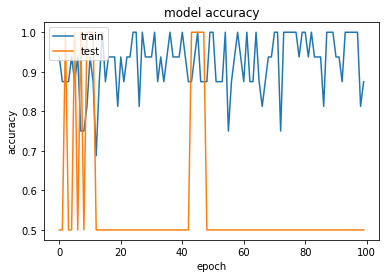

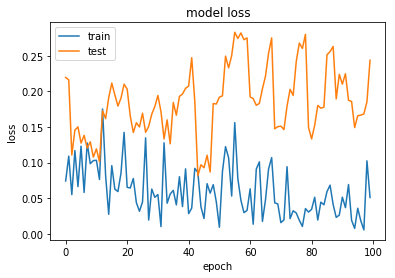

In [10]:
# List all data in history
index = 1
print(histories[index].history.keys())
# Summarize history for accuracy
plt.plot(histories[index].history['acc'])
plt.plot(histories[index].history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(histories[index].history['loss'])
plt.plot(histories[index].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Additional model evaluation

In [12]:
# Evaluate model, get metrics back
stats = model.evaluate([x_dev, x_log_dev, in_params_dev, out_params_dev], y_dev)
# Calculate predictions vector from model
predictions = model.predict([x_dev, x_log_dev, in_params_dev, out_params_dev])
predictions = np.floor(predictions + 0.5)

# Get vector mask for good and bad fits and right and wrong answers
good_fits = y_dev
bad_fits = 1 - good_fits
wrong_answers = np.abs(np.subtract(predictions, good_fits))
right_answers = np.subtract(1, wrong_answers)
# Calculate true positives (tp), as well as (tn) (fp) (fn)
true_positives = np.multiply(right_answers, good_fits)
true_negatives = np.multiply(right_answers, bad_fits)
false_positives = np.multiply(wrong_answers, good_fits)
false_negatives = np.multiply(wrong_answers, bad_fits)
# Calculate additional metrics
precision = np.sum(true_positives) / np.sum(true_positives + false_positives)
recall = np.sum(true_positives) / np.sum(true_positives + false_negatives)

# Print stats
print()
print("Performance on VALIDATION set")
print(".............................")
print("Loss: " + str(stats[0]))
print("Accuracy: " + str(stats[1]))
print("Precision: " + str(precision))
print("Recall: " + str(recall))

# Print list of indices of wrong answers
bad_list = []
for i in range(m_dev):
    if wrong_answers[i] == 1:
        bad_list.append(i)
print(".............................")
print("List of indices of wrong guesses:")
print(bad_list)

2/2 [==============================] - 0s 6ms/step

Performance on VALIDATION set
.............................
Loss: 0.33722010254859924
Accuracy: 0.5
Precision: 1.0
Recall: 0.5
.............................
List of indices of wrong guesses:
[1]


## Look at an image

label: [1]
prediction: [1.]
(236, 348, 3)


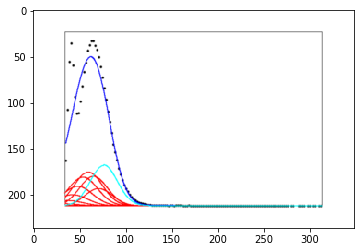

In [14]:
# Choose an index 
index = 0

# Print labels for this index
print("label: " + str(good_fits[index]))
print("prediction: " + str(predictions[index]))

# Show image
this_image = x[index]
print(str(this_image.shape))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

## Load pretrained conv model

In [25]:
# load json and create model
json_file = open('trained/conv_all.json', 'r')
conv_model_json = json_file.read()
json_file.close()
model = model_from_json(conv_model_json)
# load weights into new model
model.load_weights("trained/conv_all.h5")
print("Loaded model from disk")

Loaded model from disk


## Save convolutional model to disc

In [32]:
# serialize model to JSON
model_json = model.to_json()
with open("trained/conv_all.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("trained/conv_all.h5")
print("Saved model to disk")

Saved model to disk
